# Brain Tumor Detection

## Import Packages

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
import os
import cv2
import random
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Using TensorFlow backend.


## Load Train and Test Images in Numpy Array

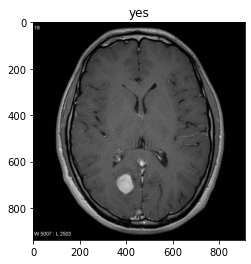

In [3]:
# This are the files where the images are stored 
TRAIN_VALID_PATH = '/Users/prathiklolla/Documents/Brain-Tumor-Detection/train+validation'
TEST_PATH = '/Users/prathiklolla/Documents/Brain-Tumor-Detection/test'

CATEGORIES = ['yes', 'no']
for category in CATEGORIES:
    path = TEST_PATH + '/' + category
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        plt.imshow(img_array, cmap = 'gray')
        plt.title(category)
        plt.show()
        break
    break

In [4]:
# Shape of a single image
img_array.shape

(938, 911, 3)

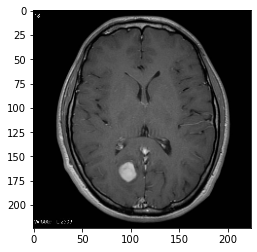

In [5]:
# Resize the images so it will be easier to feed into our model
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

In [6]:
new_array.shape

(224, 224, 3)

In [7]:
# Creating our train and test datasets
test_data = []
train_data = []

def create_train_data():
    for category in CATEGORIES:
        path = TRAIN_VALID_PATH + '/' + category
        label = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), cv2.IMREAD_COLOR)
                train_data.append([new_array, label])
            except Exception as e:
                pass
            
def create_test_data():
    for category in CATEGORIES:
        path = TEST_PATH + '/' + category
        label = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), cv2.IMREAD_COLOR)
                test_data.append([new_array, label])
            except Exception as e:
                pass

create_train_data()
create_test_data() 

random.shuffle(train_data)
random.shuffle(test_data)

In [8]:
len(train_data)

228

In [9]:
len(test_data)

25

In [10]:
# Seperating the inputs and targets
train_inputs = []
train_targets = []

test_inputs = []
test_targets = []

for features, labels in train_data:
    train_inputs.append(features)
    train_targets.append(labels)

for features, labels in test_data:
    test_inputs.append(features)
    test_targets.append(labels)
    
train_inputs = np.array(train_inputs).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
test_inputs = np.array(test_inputs).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Saving the arrays in an .npz file
np.savez('train_data', inputs = train_inputs, targets = train_targets)
np.savez('test_data', inputs = test_inputs, targets = test_targets)

In [11]:
# Opening the files
npz = np.load('train_data.npz')

train_inputs = npz['inputs']
train_inputs = train_inputs/255.

train_targets = npz['targets']

npz = np.load('test_data.npz')

test_inputs = npz['inputs']
test_inputs = test_inputs/255.

test_targets = npz['targets']

In [19]:
train_inputs.shape[1:]

(224, 224, 3)

## Model 1

### Build the Model

In [13]:
# To solve our problem we will need to make a convolutional neural network
# This will be our first model
model_reg = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (train_inputs.shape[1:])),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

### Show Model Summary

In [14]:
# Shows a brief summary on our model, whiles showing the trainable parameters
model_reg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        9

### Fit the Model

In [15]:
# To prevent overfitting we will implement an early stopping callback 
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5)

# We will use binary crossentropy as our loss function, since we have two classes 
# We will use Adam as our optimizer
model_reg.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history = model_reg.fit(train_inputs, 
                    train_targets, 
                    batch_size = 10, 
                    epochs = 30, 
                    validation_split = .1, 
                    callbacks = [early_stopping], 
                    verbose = 2)

Epoch 1/30
21/21 - 8s - loss: 0.6923 - accuracy: 0.6293 - val_loss: 0.5962 - val_accuracy: 0.6087
Epoch 2/30
21/21 - 9s - loss: 0.5940 - accuracy: 0.6293 - val_loss: 0.5718 - val_accuracy: 0.8696
Epoch 3/30
21/21 - 8s - loss: 0.5494 - accuracy: 0.7659 - val_loss: 0.4315 - val_accuracy: 0.9130
Epoch 4/30
21/21 - 7s - loss: 0.5034 - accuracy: 0.7854 - val_loss: 0.4521 - val_accuracy: 0.8261
Epoch 5/30
21/21 - 7s - loss: 0.4298 - accuracy: 0.8098 - val_loss: 0.5380 - val_accuracy: 0.6087
Epoch 6/30
21/21 - 7s - loss: 0.3905 - accuracy: 0.8195 - val_loss: 0.4064 - val_accuracy: 0.8696
Epoch 7/30
21/21 - 7s - loss: 0.2879 - accuracy: 0.8878 - val_loss: 0.5038 - val_accuracy: 0.7391
Epoch 8/30
21/21 - 7s - loss: 0.1530 - accuracy: 0.9415 - val_loss: 0.7655 - val_accuracy: 0.7391
Epoch 9/30
21/21 - 7s - loss: 0.0672 - accuracy: 0.9707 - val_loss: 0.8833 - val_accuracy: 0.6957
Epoch 10/30
21/21 - 7s - loss: 0.0356 - accuracy: 0.9854 - val_loss: 1.1996 - val_accuracy: 0.6957
Epoch 11/30
21/21 -

array([[0.]], dtype=float32)

### Visualize Model Performance

Using Ruslan Klymentiev's method to show model loss and accuracy
Link to his Kaggle kernel: 
https://www.kaggle.com/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16

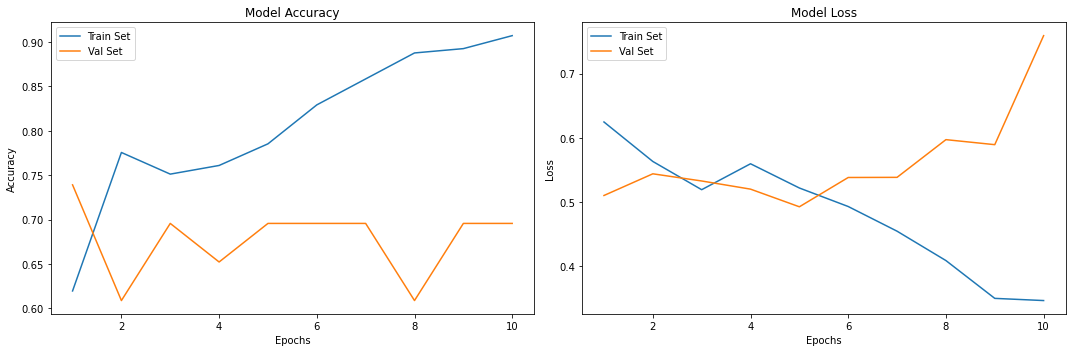

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Get Model Predicitions

In [15]:
# Using the model to classify the test data
test_pred_reg = model_reg.predict(test_inputs)
test_pred_reg = [1 if x > 0.5 else 0 for x in test_pred_reg]

# shows the precision, recall and f1-scores for each class
print(classification_report(test_targets, test_pred_reg))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        12
           1       1.00      0.54      0.70        13

    accuracy                           0.76        25
   macro avg       0.83      0.77      0.75        25
weighted avg       0.84      0.76      0.75        25



## Data Augmentation

We will use data augmentation to artificially expand our dataset by making modified versions of the images.

In [16]:
BATCH_SIZE = 10

datagen_1 = ImageDataGenerator(rescale = 1/255.,
                              rotation_range = 0.10,
                              height_shift_range = 0.2,
                              width_shift_range = 0.2,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True,
                              fill_mode = 'nearest',
                              validation_split = 0.1)

training_generator = datagen_1.flow_from_directory(TRAIN_VALID_PATH,
                                                  target_size = (IMG_SIZE, IMG_SIZE),
                                                  batch_size = BATCH_SIZE, 
                                                  class_mode = 'binary',
                                                  subset = 'training')
validation_generator = datagen_1.flow_from_directory(TRAIN_VALID_PATH,
                                                  target_size = (IMG_SIZE, IMG_SIZE),
                                                  batch_size = BATCH_SIZE, 
                                                  class_mode = 'binary',
                                                  subset = 'validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  target_size = (IMG_SIZE, IMG_SIZE),
                                                  color_mode = 'rgb',
                                                  shuffle = True,
                                                  class_mode = 'binary',
                                                  batch_size = 1)

Found 206 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


## Model 2

We will use a similar model to see the effect of data augmentation. We will only change the input shape.

In [17]:
model_da = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

### Fit the Model

In [18]:
model_da.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history_da = model_da.fit(
        training_generator,
        steps_per_epoch = 10,
        epochs = 30,
        batch_size = 10,
        validation_data = validation_generator,
        validation_steps = 2,
        callbacks = [early_stopping],
        verbose = 2)

Epoch 1/30
10/10 - 4s - loss: 0.6737 - accuracy: 0.6000 - val_loss: 0.6076 - val_accuracy: 0.6500
Epoch 2/30
10/10 - 4s - loss: 0.6293 - accuracy: 0.6400 - val_loss: 0.6035 - val_accuracy: 0.6500
Epoch 3/30
10/10 - 4s - loss: 0.6650 - accuracy: 0.5729 - val_loss: 0.6342 - val_accuracy: 0.6000
Epoch 4/30
10/10 - 4s - loss: 0.6211 - accuracy: 0.7500 - val_loss: 0.6615 - val_accuracy: 0.6500
Epoch 5/30
10/10 - 4s - loss: 0.5866 - accuracy: 0.6771 - val_loss: 0.5743 - val_accuracy: 0.7000
Epoch 6/30
10/10 - 4s - loss: 0.6095 - accuracy: 0.7300 - val_loss: 0.6670 - val_accuracy: 0.7000
Epoch 7/30
10/10 - 4s - loss: 0.6227 - accuracy: 0.6875 - val_loss: 0.6081 - val_accuracy: 0.6000
Epoch 8/30
10/10 - 4s - loss: 0.6341 - accuracy: 0.7100 - val_loss: 0.6417 - val_accuracy: 0.6500
Epoch 9/30
10/10 - 4s - loss: 0.6328 - accuracy: 0.6562 - val_loss: 0.5490 - val_accuracy: 0.9000
Epoch 10/30
10/10 - 4s - loss: 0.5742 - accuracy: 0.7300 - val_loss: 0.7203 - val_accuracy: 0.6500
Epoch 11/30
10/10 -

### Visualize Model Performance

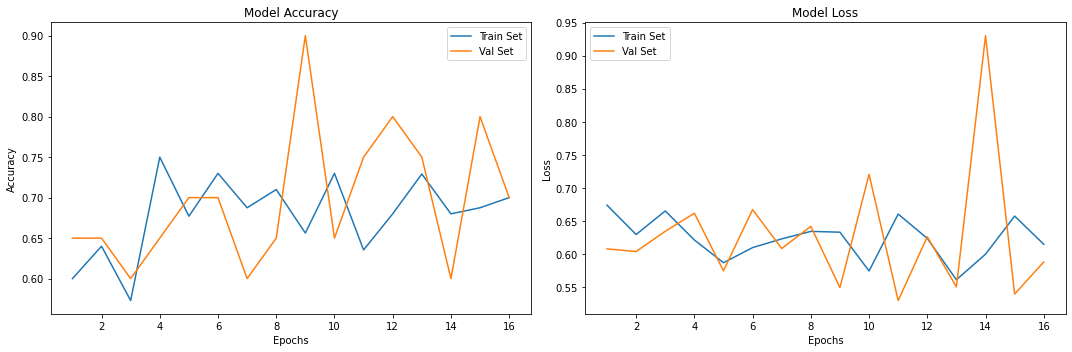

In [19]:
# plot model performance
acc = history_da.history['accuracy']
val_acc = history_da.history['val_accuracy']
loss = history_da.history['loss']
val_loss = history_da.history['val_loss']
epochs_range = range(1, len(history_da.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Get Test Predictions

In [20]:
num_test_files = len(test_generator.filenames)

test_pred_da = model_da.predict(test_generator, steps = num_test_files)
test_pred_da = [1 if x > 0.5 else 0 for x in test_pred_da]


print(classification_report(test_targets, test_pred_da))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.43      0.69      0.53        13

    accuracy                           0.36        25
   macro avg       0.21      0.35      0.26        25
weighted avg       0.22      0.36      0.28        25



Looks like data augmentation is leading to a lower accuracy, so it may not be best to use this.

Let's try using pretrained models to get a better accuracy.

## Model 3 (MobileNetV2)

In [21]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Creating the base of our model using MobileNetV2
base_model_v2 = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet')

In [22]:
# We are freezing the base of our model, because we don't want to train all of its parameters, just the ones we need for our problem
base_model_v2.trainable = False
base_model_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

### Build Model

In [23]:
model_mnv2 = tf.keras.models.Sequential()

model_mnv2.add(base_model_v2)
model_mnv2.add(tf.keras.layers.GlobalAveragePooling2D())
model_mnv2.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [24]:
model_mnv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### Fit the Model

In [25]:
EPOCHS = 50

model_mnv2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history_mnv2 = model_mnv2.fit(
    train_inputs,
    train_targets,
    epochs = EPOCHS,
    batch_size = 10,
    validation_split = 0.1,
    callbacks = [early_stopping],
    verbose = 2)

Epoch 1/50
21/21 - 4s - loss: 0.6916 - accuracy: 0.5463 - val_loss: 0.5896 - val_accuracy: 0.7391
Epoch 2/50
21/21 - 4s - loss: 0.4996 - accuracy: 0.7561 - val_loss: 0.4808 - val_accuracy: 0.9130
Epoch 3/50
21/21 - 4s - loss: 0.3967 - accuracy: 0.8683 - val_loss: 0.4384 - val_accuracy: 0.9130
Epoch 4/50
21/21 - 4s - loss: 0.3430 - accuracy: 0.8829 - val_loss: 0.4130 - val_accuracy: 0.8696
Epoch 5/50
21/21 - 4s - loss: 0.2870 - accuracy: 0.9317 - val_loss: 0.4158 - val_accuracy: 0.8261
Epoch 6/50
21/21 - 4s - loss: 0.2589 - accuracy: 0.9366 - val_loss: 0.4142 - val_accuracy: 0.8261
Epoch 7/50
21/21 - 4s - loss: 0.2391 - accuracy: 0.9366 - val_loss: 0.3893 - val_accuracy: 0.8261
Epoch 8/50
21/21 - 4s - loss: 0.2255 - accuracy: 0.9317 - val_loss: 0.4148 - val_accuracy: 0.8261
Epoch 9/50
21/21 - 4s - loss: 0.2024 - accuracy: 0.9561 - val_loss: 0.3996 - val_accuracy: 0.8261
Epoch 10/50
21/21 - 4s - loss: 0.1908 - accuracy: 0.9512 - val_loss: 0.4237 - val_accuracy: 0.8261
Epoch 11/50
21/21 -

### Visualize Model Performance

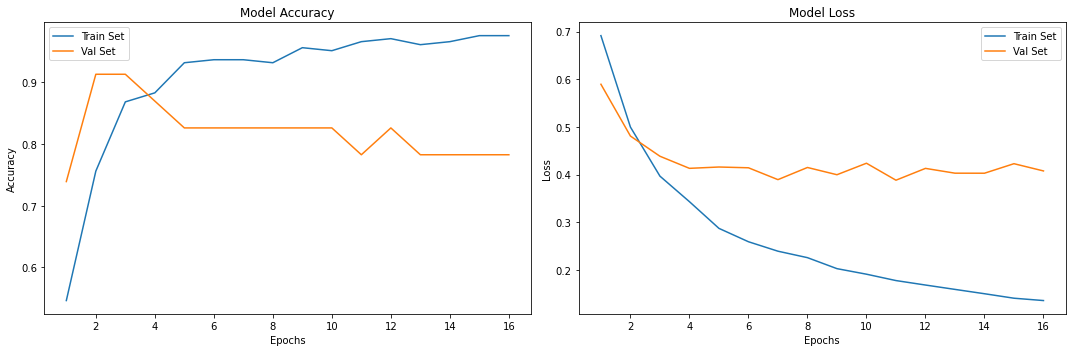

In [26]:
# plot model performance
acc = history_mnv2.history['accuracy']
val_acc = history_mnv2.history['val_accuracy']
loss = history_mnv2.history['loss']
val_loss = history_mnv2.history['val_loss']
epochs_range = range(1, len(history_mnv2.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Get Model Predictions

In [27]:
test_pred_mnv2 = model_mnv2.predict(test_inputs, steps = num_test_files)
test_pred_mnv2 = [1 if x > 0.5 else 0 for x in test_pred_mnv2]

print(classification_report(test_targets, test_pred_mnv2))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.92      0.92      0.92        13

    accuracy                           0.92        25
   macro avg       0.92      0.92      0.92        25
weighted avg       0.92      0.92      0.92        25



## Model 4 (VGG-16)

Same process as last time, except with a different base model.

In [28]:
base_model_vgg = tf.keras.applications.VGG16(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet')

In [29]:
base_model_vgg.trainable = False
base_model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Build the Model

In [30]:
model_vgg = tf.keras.models.Sequential()

model_vgg.add(base_model_vgg)
model_vgg.add(tf.keras.layers.GlobalAveragePooling2D())
model_vgg.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


### Fit the Model

In [31]:
model_vgg.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history_vgg = model_vgg.fit(
    train_inputs,
    train_targets,
    epochs = EPOCHS,
    batch_size = 10,
    validation_split = 0.1,
    callbacks = [early_stopping],
    verbose = 2)

Epoch 1/50
21/21 - 32s - loss: 0.6814 - accuracy: 0.6244 - val_loss: 0.6146 - val_accuracy: 0.6522
Epoch 2/50
21/21 - 29s - loss: 0.6567 - accuracy: 0.6244 - val_loss: 0.6144 - val_accuracy: 0.6522
Epoch 3/50
21/21 - 31s - loss: 0.6420 - accuracy: 0.6293 - val_loss: 0.6011 - val_accuracy: 0.6522
Epoch 4/50
21/21 - 30s - loss: 0.6292 - accuracy: 0.6244 - val_loss: 0.5935 - val_accuracy: 0.6522
Epoch 5/50
21/21 - 30s - loss: 0.6163 - accuracy: 0.6244 - val_loss: 0.5882 - val_accuracy: 0.6522
Epoch 6/50
21/21 - 30s - loss: 0.6038 - accuracy: 0.6439 - val_loss: 0.5820 - val_accuracy: 0.6522
Epoch 7/50
21/21 - 30s - loss: 0.5929 - accuracy: 0.6732 - val_loss: 0.5768 - val_accuracy: 0.6957
Epoch 8/50
21/21 - 30s - loss: 0.5864 - accuracy: 0.6976 - val_loss: 0.5722 - val_accuracy: 0.6957
Epoch 9/50
21/21 - 30s - loss: 0.5767 - accuracy: 0.6780 - val_loss: 0.5674 - val_accuracy: 0.7391
Epoch 10/50
21/21 - 31s - loss: 0.5633 - accuracy: 0.7073 - val_loss: 0.5635 - val_accuracy: 0.7391
Epoch 11/

### Visualize Model Performance

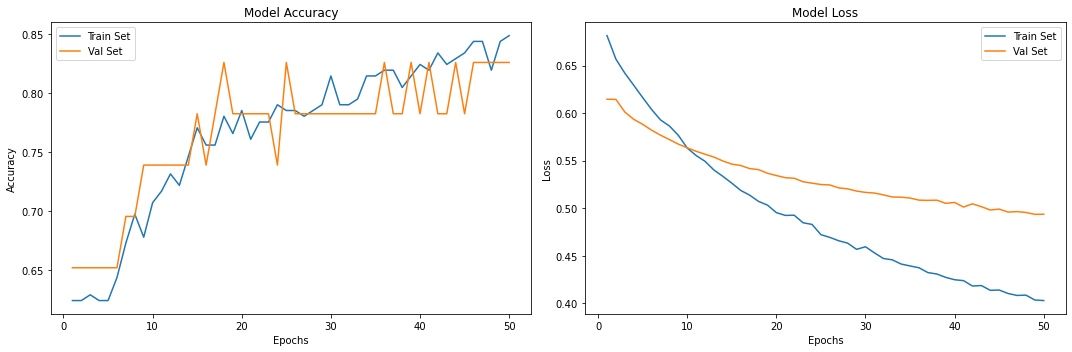

In [32]:
# plot model performance
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs_range = range(1, len(history_vgg.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Get Model Predictions

In [33]:
test_pred_vgg = model_vgg.predict(test_inputs, steps = num_test_files)
test_pred_vgg = [1 if x > 0.5 else 0 for x in test_pred_vgg]

print(classification_report(test_targets, test_pred_vgg))

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.80      0.62      0.70        13

    accuracy                           0.72        25
   macro avg       0.73      0.72      0.72        25
weighted avg       0.74      0.72      0.72        25



## Model 5 (ResNet50)

In [34]:
base_model_rn50 = tf.keras.applications.ResNet50(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet')

In [35]:
base_model_rn50.trainable = False
base_model_rn50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Build Model

In [37]:
model_rn50 = tf.keras.models.Sequential()

model_rn50.add(base_model_rn50)
model_rn50.add(tf.keras.layers.GlobalAveragePooling2D())
model_rn50.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model_rn50.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


### Fit the Model

In [38]:
EPOCHS = 50

model_rn50.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history_rn50 = model_rn50.fit(
    train_inputs,
    train_targets,
    epochs = EPOCHS,
    batch_size = 10,
    validation_split = 0.1,
    callbacks = [early_stopping],
    verbose = 2)

Epoch 1/50
21/21 - 13s - loss: 0.8202 - accuracy: 0.5024 - val_loss: 0.6673 - val_accuracy: 0.6522
Epoch 2/50
21/21 - 12s - loss: 0.6641 - accuracy: 0.6244 - val_loss: 0.6408 - val_accuracy: 0.6522
Epoch 3/50
21/21 - 11s - loss: 0.6701 - accuracy: 0.5756 - val_loss: 0.6219 - val_accuracy: 0.6522
Epoch 4/50
21/21 - 11s - loss: 0.6366 - accuracy: 0.6244 - val_loss: 0.6092 - val_accuracy: 0.6957
Epoch 5/50
21/21 - 11s - loss: 0.6230 - accuracy: 0.6488 - val_loss: 0.5906 - val_accuracy: 0.6522
Epoch 6/50
21/21 - 11s - loss: 0.6123 - accuracy: 0.6585 - val_loss: 0.5868 - val_accuracy: 0.7391
Epoch 7/50
21/21 - 11s - loss: 0.6033 - accuracy: 0.7073 - val_loss: 0.5691 - val_accuracy: 0.6957
Epoch 8/50
21/21 - 11s - loss: 0.5970 - accuracy: 0.6878 - val_loss: 0.5618 - val_accuracy: 0.7391
Epoch 9/50
21/21 - 11s - loss: 0.5887 - accuracy: 0.7171 - val_loss: 0.5535 - val_accuracy: 0.7391
Epoch 10/50
21/21 - 11s - loss: 0.5832 - accuracy: 0.7024 - val_loss: 0.5480 - val_accuracy: 0.6957
Epoch 11/

### Visualize Model Performance

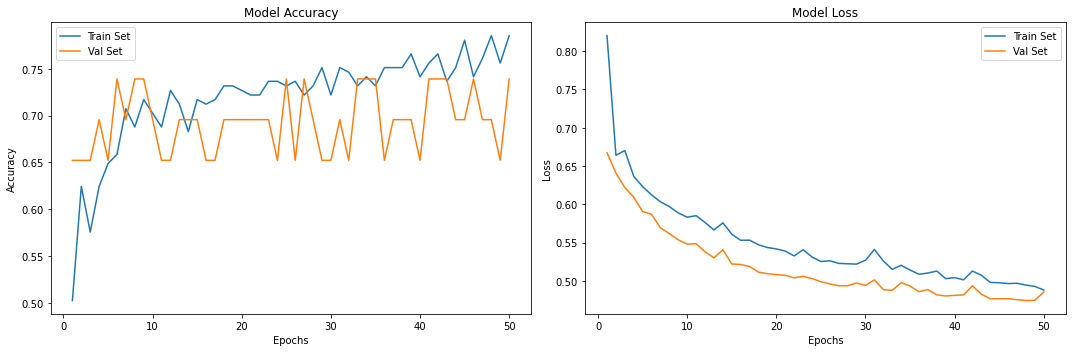

In [39]:
# plot model performance
acc = history_rn50.history['accuracy']
val_acc = history_rn50.history['val_accuracy']
loss = history_rn50.history['loss']
val_loss = history_rn50.history['val_loss']
epochs_range = range(1, len(history_rn50.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Get Model Predictions

In [40]:
test_pred_rn50 = model_rn50.predict(test_inputs, steps = num_test_files)
test_pred_rn50 = [1 if x > 0.5 else 0 for x in test_pred_rn50]

print(classification_report(test_targets, test_pred_rn50))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75        12
           1       1.00      0.38      0.56        13

    accuracy                           0.68        25
   macro avg       0.80      0.69      0.65        25
weighted avg       0.81      0.68      0.65        25



## Conclusions

The MobileNetV2 model is the best for this problem as it yields the most accurate.

## Save Best Performing Model

In [ ]:
model_mnv2.save('/Users/prathiklolla/Documents/Brain-Tumor-Detection/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/prathiklolla/Documents/Brain-Tumor-Detection/assets
